In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import sklearn.metrics
import spicy
from scipy.stats import gaussian_kde

In [2]:
data = pd.read_csv("C:/Users/Administrator/Desktop/car_prices.csv")
data.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558837 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558837 non-null  int64  
 1   make          548536 non-null  object 
 2   model         548438 non-null  object 
 3   trim          548186 non-null  object 
 4   body          545642 non-null  object 
 5   transmission  493485 non-null  object 
 6   vin           558833 non-null  object 
 7   state         558837 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558743 non-null  float64
 10  color         558088 non-null  object 
 11  interior      558088 non-null  object 
 12  seller        558837 non-null  object 
 13  mmr           558799 non-null  float64
 14  sellingprice  558825 non-null  float64
 15  saledate      558825 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 68.2+ MB


# Project overview
-  Miêu tả datasheet
    -  Size: 558837 Data Points
    -  Features: 16
        - Feature số lượng:
        
        
        | Feature Name | Data Type | Description                                                                                   |
        |--------------|-----------|-----------------------------------------------------------------------------------------------|
        | year         | int64     | Năm sản xuất xe.                                                              |
        | condition    | float64   | Tình trạng xe (Trên thang 0-50).                                     |
        | odometer     | float64   | Số dặm xe đã đi.                                                                         |
        | mmr          | float64   | Giá dự đoán thị trường của xe.                                       |
        | sellingprice | float64   | Giá bán cuối của xe .                                                 |
        - Feature chất lượng:
        
        | Feature Name | Data Type | Description                                                                                   |
        |--------------|-----------|-----------------------------------------------------------------------------------------------|
        | make         | object    | Hãng xe.                                                              |
        | model        | object    | Mẫu xe.                                                                 |
        | trim         | object    | Thông tin thêm về xe.                                                     |
        | body         | object    | Mẫu thân xe (vd: Sedan, SUV, etc.).                                              |
        | transmission | object    | Mẫu hộp số (automatic, manual).                                             |
        | vin          | object    | Số series xe.                                            |
        | state        | object    | Bang đăng kí xe.                                                     |
        | color        | object    | Màu ngoại thất.                                                                 |
        | interior     | object    | Màu nội thất.                                                                 |
        | seller       | object    | Người/công ti/tập đoàn bán xe.                                                              |
        | saledate     | object    | Thời gian bán xe.                                                                 |


# Xử lý data

- Vì những feature chất lượng có ảnh hưởng không nhiều tới giá bán cuối nên ta sẽ thực hiện drop những feature này


In [4]:
data.drop(['make','model','trim','body','transmission','vin','state','color','interior','seller','saledate'],axis=1,inplace=True)

year                0
condition       11820
odometer           94
mmr                38
sellingprice       12
dtype: int64


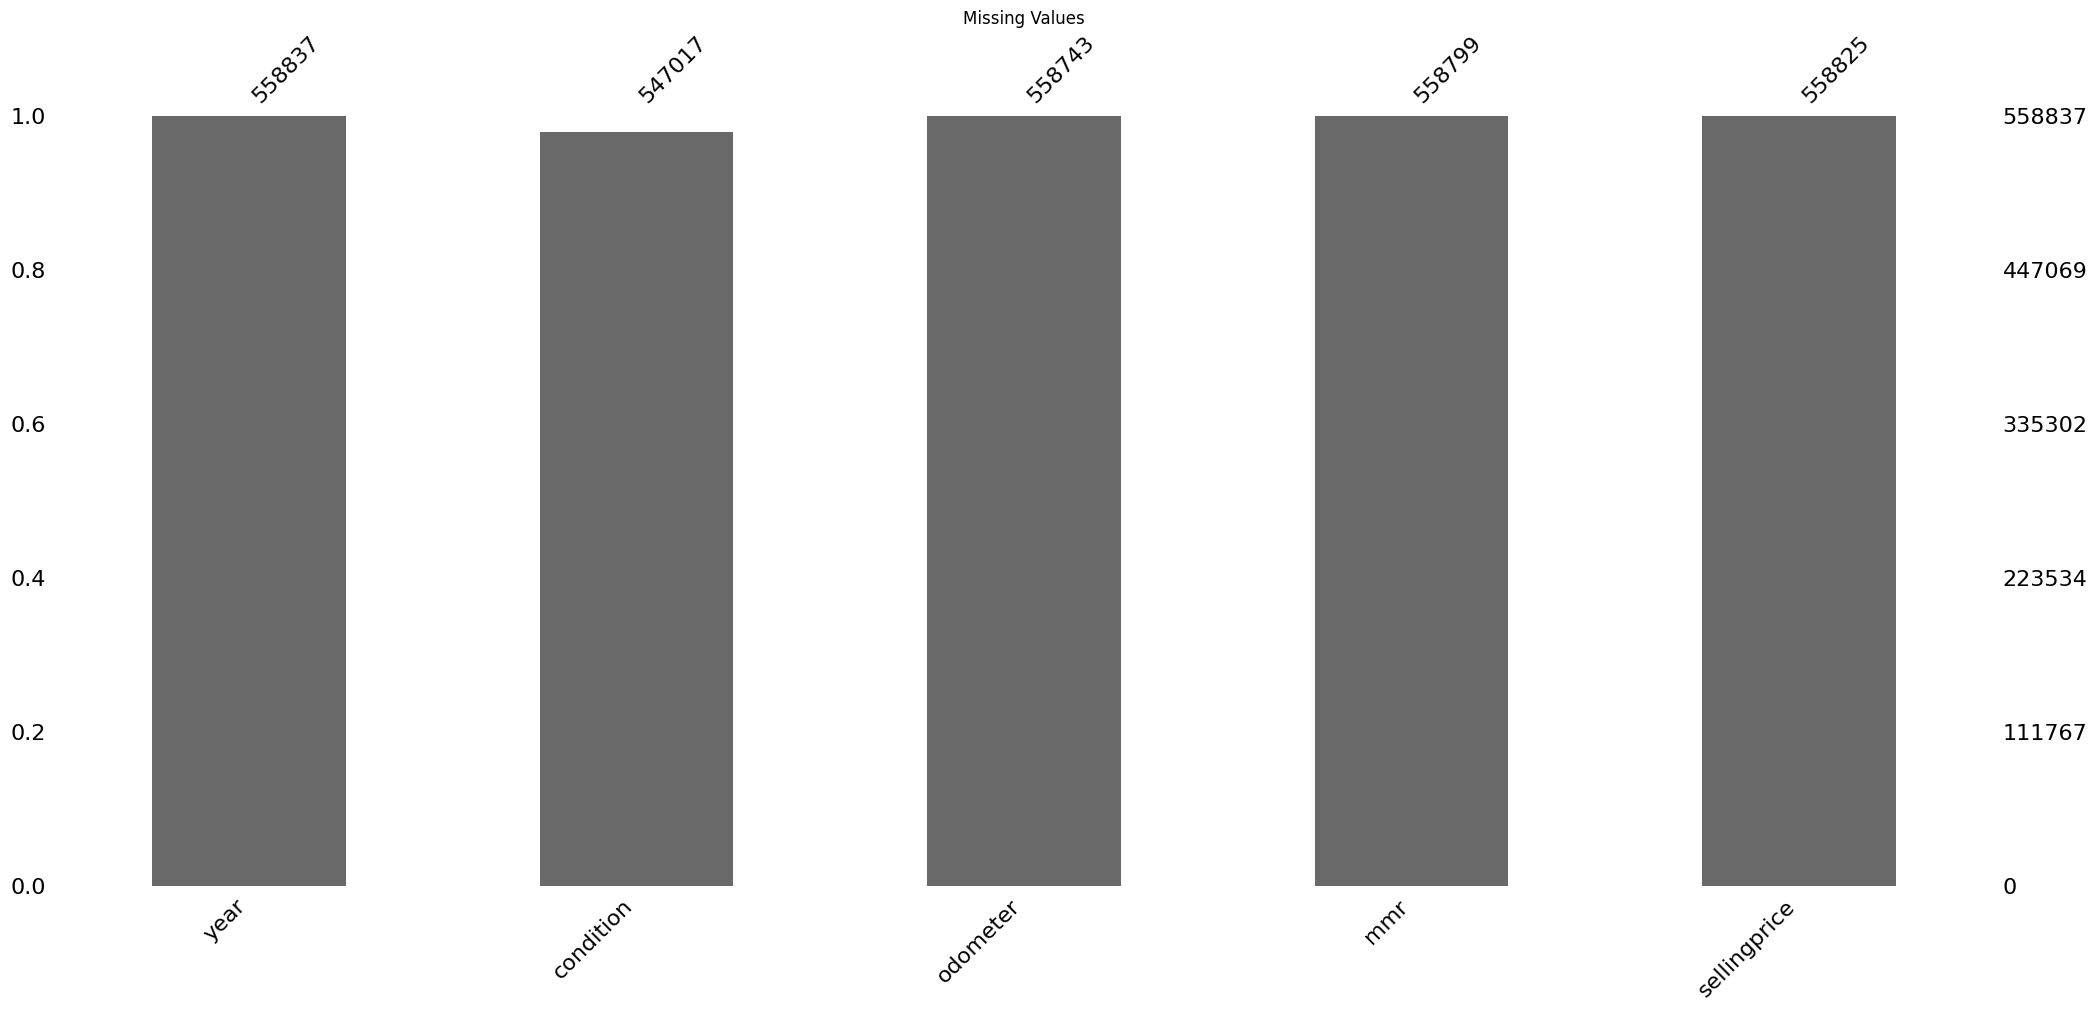

In [5]:
# Kiểm tra số lượng data bị thiếu (Null)

print (data.isnull().sum())
msno.bar(data)
plt.title("Missing Values")
plt.show()

## Nhận xét số liệu thiếu (Null)
 - Dữ liệu thiếu nhiều nhất: condition(11820)
 - Dữ liệu không thiếu: Năm sản xuất
 - Dữ liệu nhìn chung thiếu rất ít
 - Dữ liệu target variable(Giá bán) thiếu 12 => drop 12 datapoints không có dữ liệu 

## Xử lý dữ liệu thiếu

In [6]:
#xử lý dữ liệu

#Đổi các dữ liệu số lượng Null thành Median
data.loc[:,'condition'] = data.loc[:,['condition']].fillna(data['condition'].mean())
data.loc[:,'odometer'] = data.loc[:,['odometer']].fillna(data['odometer'].mean())
data.loc[:,'mmr'] = data.loc[:,['mmr']].fillna(data['mmr'].mean())

#Drop dữ liệu target variable Null
data.dropna(subset=['sellingprice'],axis='rows',inplace=True)

In [7]:
#Tạo cột mới tuổi của xe và bỏ năm sản xuất
data['car_age']=data['year'].apply(lambda x: 2024-x)
data.drop(['year'],axis=1,inplace=True)

- Chúng ta sẽ chấp nhận sai số khi thay đổi data số thành Median
- Tuy nhiên, vì có rất nhiều data points so với số lượng dữ liệu bị thay đổi, những sai số này là rất nhỏ


## Dữ liệu sample train/test 

In [8]:
#Sample 20% dữ liệu gốc làm dữ liệu test
data_test=data.sample(frac=0.2)
#Drop các dữ liệu test 
data=data.drop(data_test.index)
data_test.info()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111765 entries, 157202 to 69575
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   condition     111765 non-null  float64
 1   odometer      111765 non-null  float64
 2   mmr           111765 non-null  float64
 3   sellingprice  111765 non-null  float64
 4   car_age       111765 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 5.1 MB
<class 'pandas.core.frame.DataFrame'>
Index: 447060 entries, 1 to 558836
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   condition     447060 non-null  float64
 1   odometer      447060 non-null  float64
 2   mmr           447060 non-null  float64
 3   sellingprice  447060 non-null  float64
 4   car_age       447060 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 20.5 MB


### Xác định quan hệ giữa các chỉ số trên và giá bán thực tế

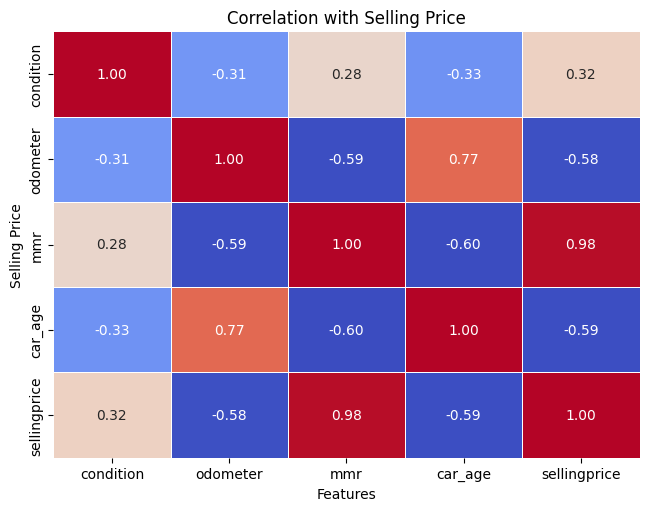

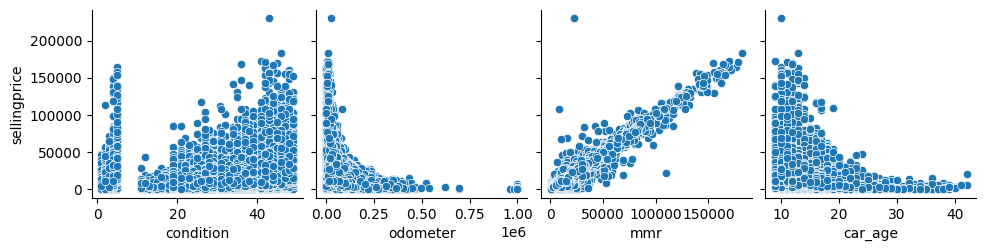

In [9]:
plt.figure()
numeric_cols = ['condition','odometer','mmr','car_age','sellingprice']

sns.heatmap(data[numeric_cols].corr(),
            cmap='coolwarm',
            annot=True,
            fmt='.2f',               
            linewidths=0.5,          
            cbar = False,             
            )

plt.tight_layout()
plt.title('Correlation with Selling Price')
plt.xlabel('Features')
plt.ylabel('Selling Price')
plt.show()

selected_features= data.drop('sellingprice',axis=1)
sns.pairplot(data,x_vars=selected_features,y_vars='sellingprice',kind='scatter',diag_kind='kde')
plt.show()

- Ta có thể thấy, các số liệu trên có ảnh hưởng nhất đinh tới giá bán thực tế:
   - Tuổi của xe và số dặm xe đã đi được có tỉ lệ nghịch với nhau
   - Tình trạng xe có tỉ lệ tích cực với giá bán thực của xe
   - Giá dự đoán có tỉ lệ anh hưởng rất cao tới giá bán thực của xe


# Simple Linear Regression
- Dùng làm điểm so sánh sau khi đặt tất cả các feature với nhau khi làm Multiple Linear Regression



In [10]:
#Tạo function Simple Linear Regression
def SLReg(data):
    X=data[['mmr']]
    y=data[['sellingprice']]

    model = LinearRegression()
    model.fit(X,y)
    predictions = model.predict(X)

    return(model, predictions, y)

## Biểu đồ quan hệ giữa giá ước tính và giá bán

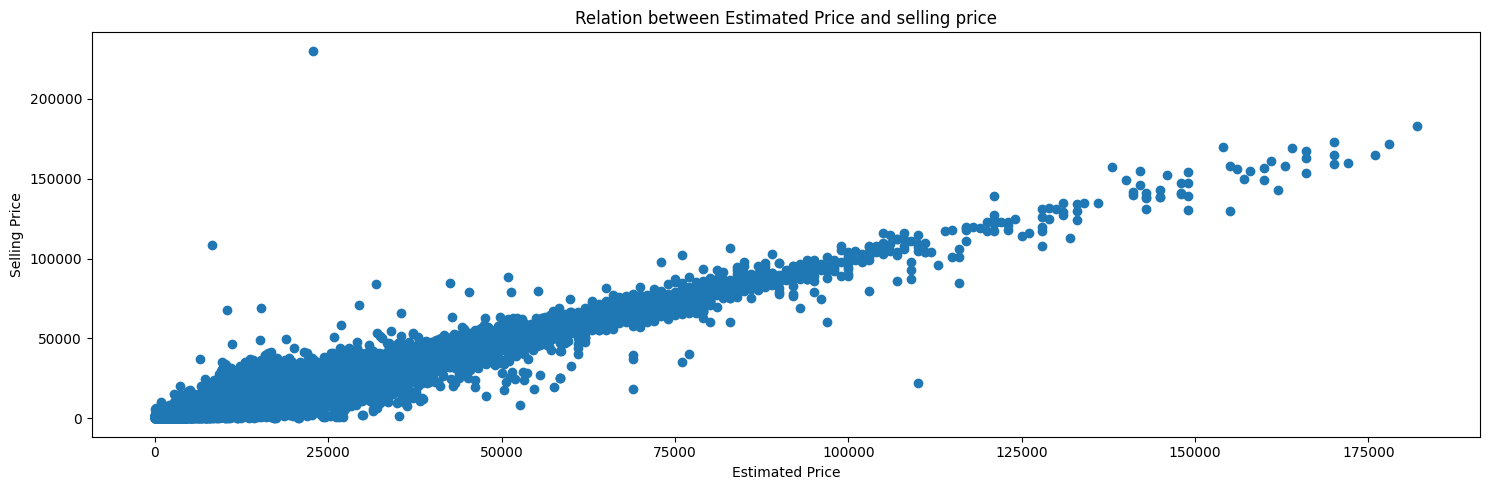

In [11]:
plt.figure(figsize=(15,5))
plt.scatter(data['mmr'],data['sellingprice'])
plt.xlabel("Estimated Price")
plt.ylabel('Selling Price')
plt.title("Relation between Estimated Price and selling price")
plt.tight_layout()
plt.show()

- Biểu đồ cho thấy giá dự đoán có liên kết tuyến tính với giá bán thực tế

## Linear Regression với dữ liệu chưa được lọc

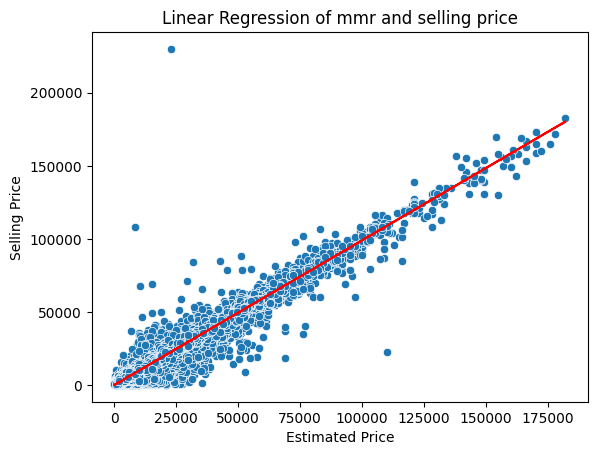

RMSE =  1761.0637576288193
MSE =  3101345.558433737
MAE =  1090.93605496015
R^2 Score =  0.9675720362096518
Explained Variance Score =  0.9675720362096518


In [12]:
#Call function SLReg
model, predictions, y = SLReg(data)
#Một số hàm mất mát
RMSE=np.sqrt(sk.metrics.mean_squared_error(y, predictions))
MSE=sk.metrics.mean_squared_error(y, predictions)
MAE=sk.metrics.mean_absolute_error(y, predictions)

#Plot data và đường hồi quy
sns.scatterplot(data=data,x='mmr',y='sellingprice')
plt.plot(data['mmr'],predictions,color='red')
plt.title('Linear Regression of mmr and selling price')
plt.xlabel('Estimated Price')
plt.ylabel('Selling Price')
plt.show()

#Đánh giá model
print('RMSE = ', RMSE)
print('MSE = ', MSE)
print('MAE = ', MAE )
print('R^2 Score = ', sk.metrics.r2_score(y,predictions))
print('Explained Variance Score = ', sk.metrics.explained_variance_score(y,predictions))



#### Nhận xét dữ liệu Simple Linear Regression model với dữ liệu chưa được lọc
 - Model có độ chuẩn cao với các điểm R^2 và Explained Variance sấp sỉ 0.97 
 - Các hàm mất mát RMSE và MSE cho ra kết quả khá thấp
 - Tuy nhiên kết quả của hàm MSE cho ra rất cao vì chưa lọc các dữ liệu outliar như trên hình

## Thực hiện lọc các dữ liệu outliar


### Nhận xét dữ liệu gốc 

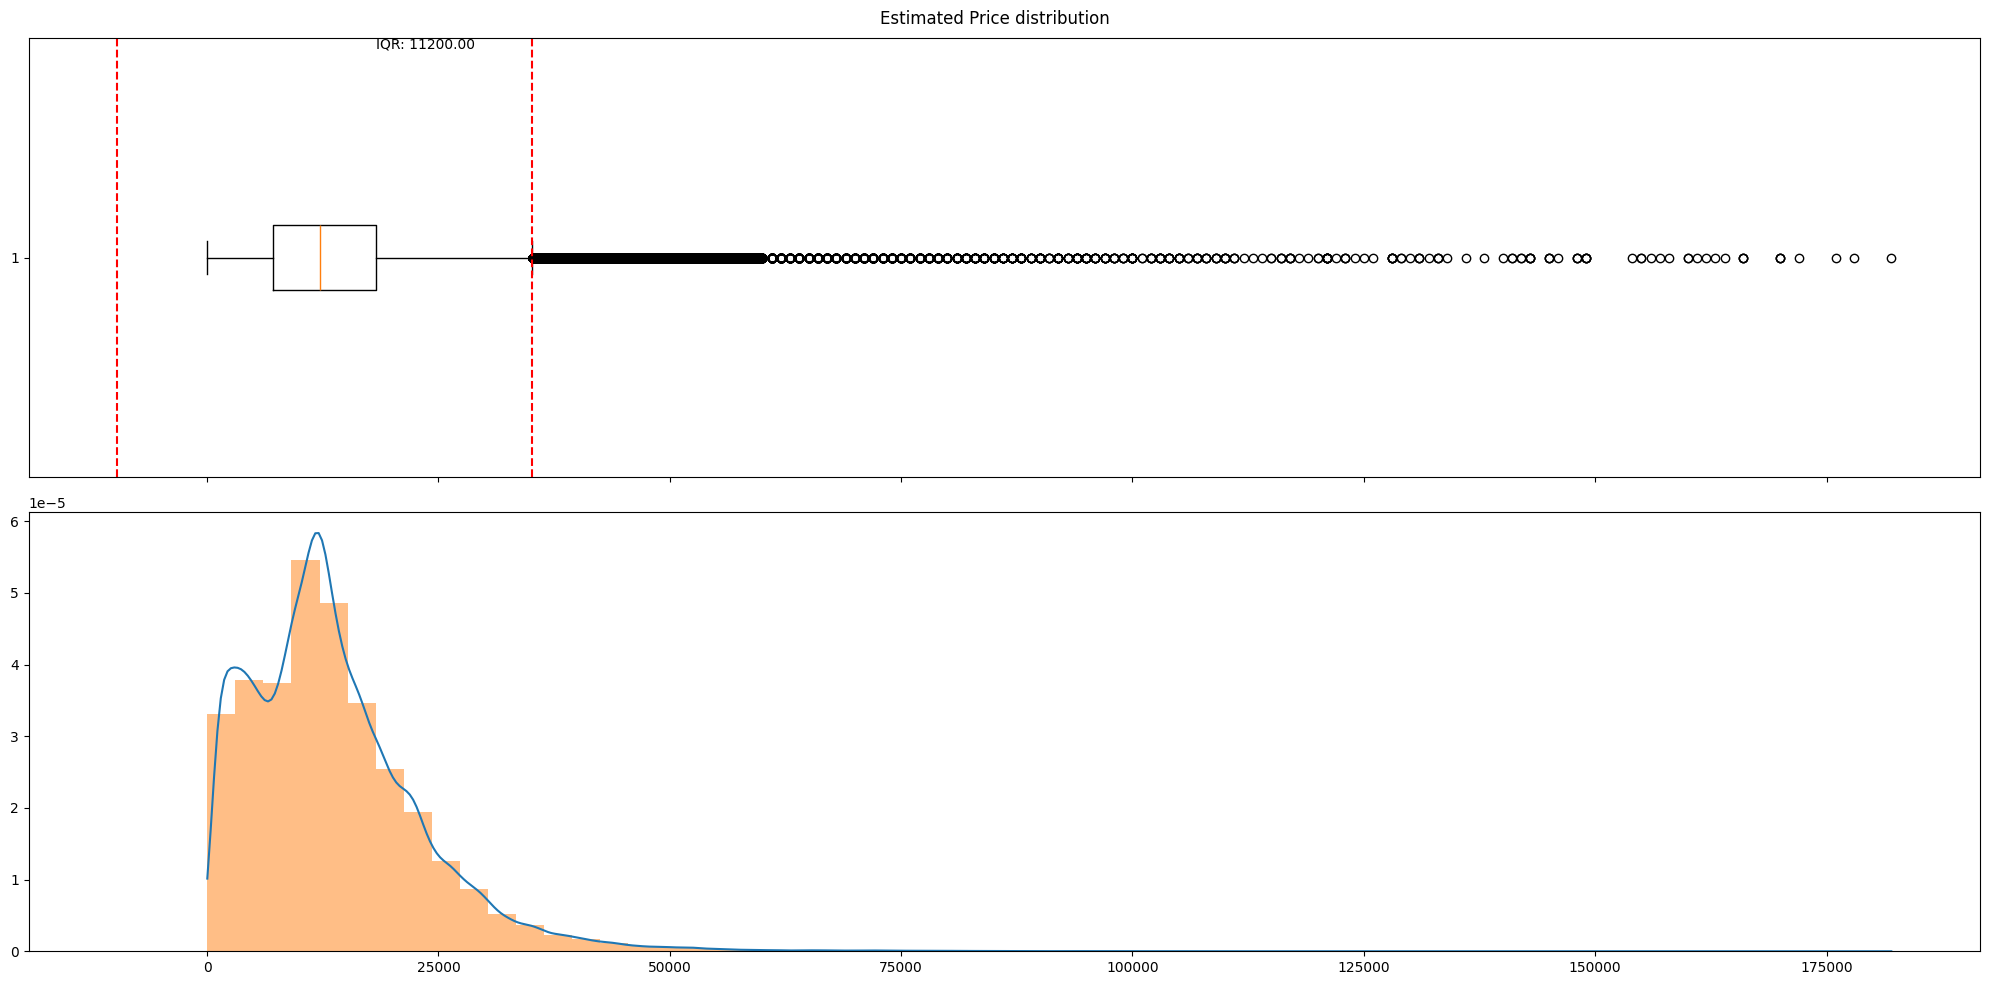

Q1 =  7100.0
Q3 =  18300.0
Giới hạn trên =  35100.0
Giới hạn dưới =  -9700.0


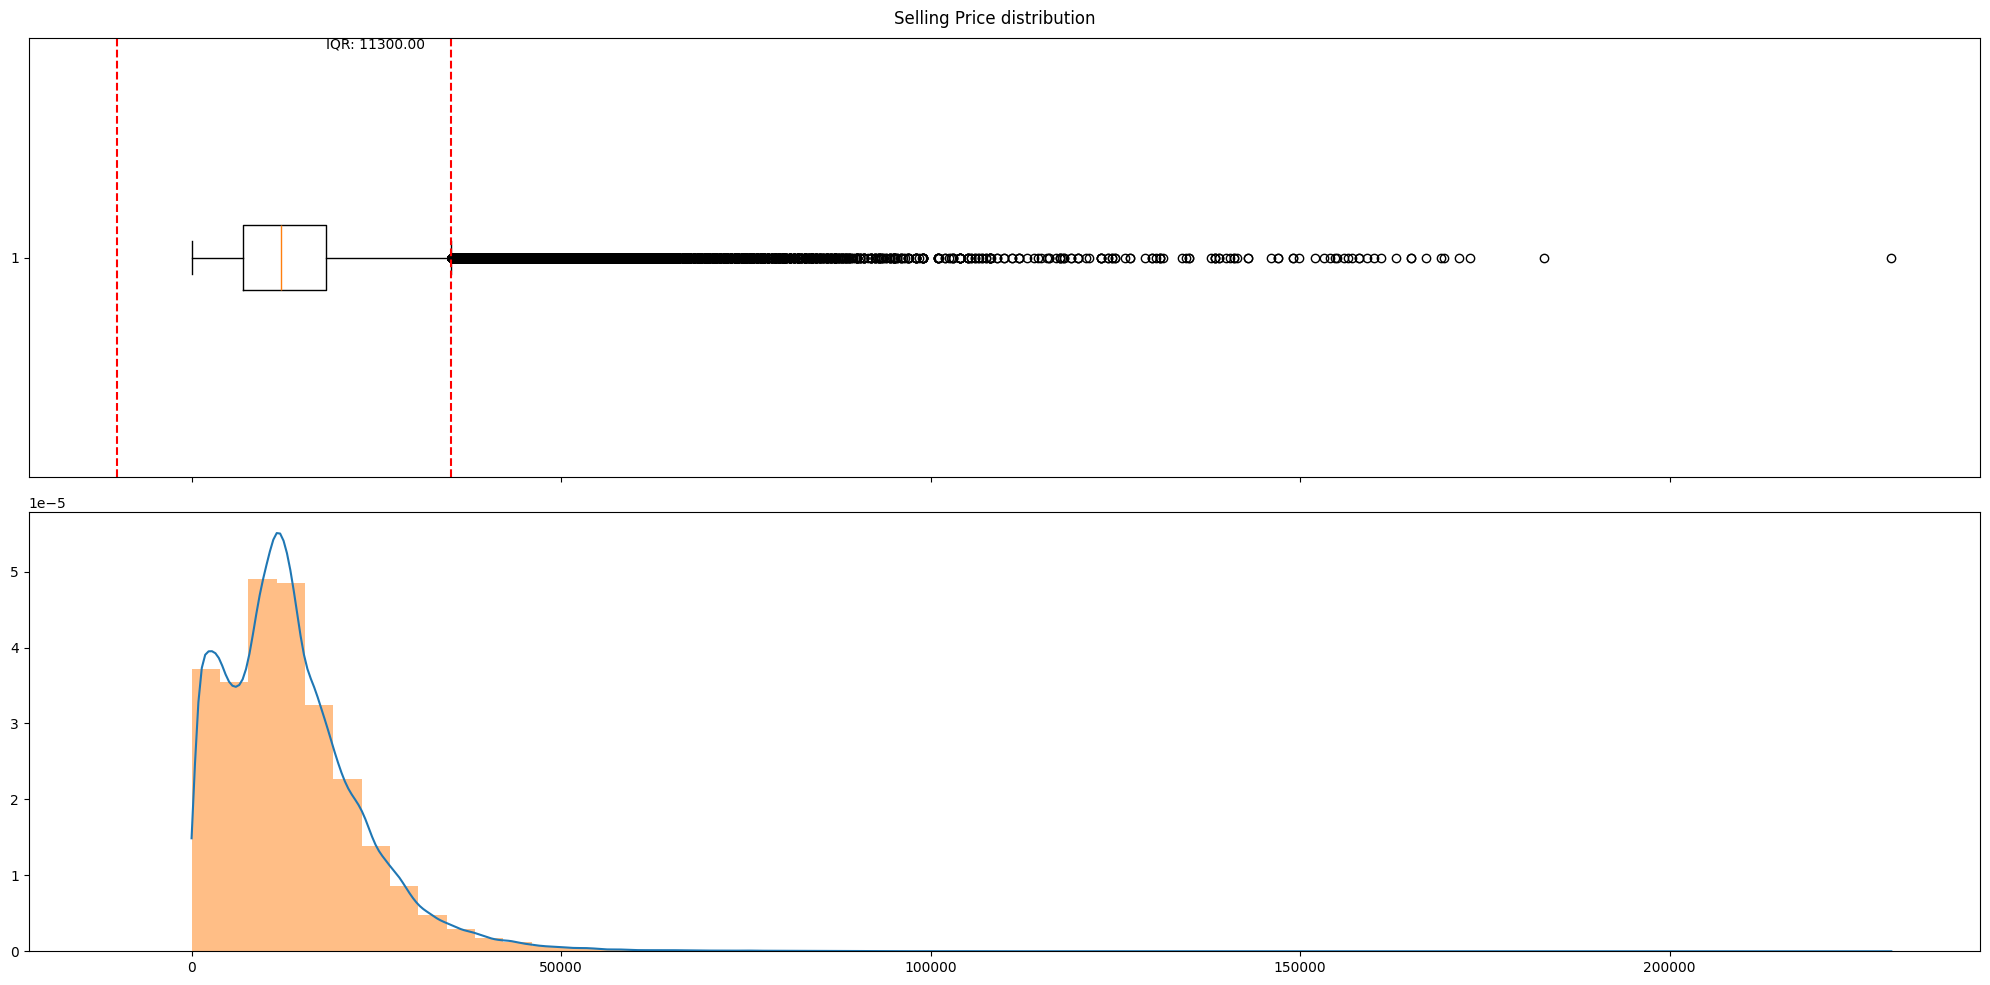

Q1 =  6900.0
Q3 =  18200.0
Giới hạn trên =  35150.0
Giới hạn dưới =  -10050.0


In [13]:
#Plot distribution của Estimated Price
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(20,10),sharex=True)

kde = gaussian_kde(data['mmr'])
kde_x = np.linspace(data['mmr'].min(), data['mmr'].max(), 500)

ax[0].boxplot(data['mmr'],vert=False)

kde_y = kde(kde_x)

#IQR
Q1 = np.percentile(data['mmr'], 25)
Q3 = np.percentile(data['mmr'], 75)
IQR = Q3 - Q1

#Plot settings

ax[1].plot(kde_x, kde_y, label='KDE')
ax[1].hist(data['mmr'],bins=60,alpha=0.5,density=True)
ax[0].axvline(Q1-1.5*IQR, color='r', linestyle='--')
ax[0].axvline(Q3+1.5*IQR, color='r', linestyle='--')
ax[0].text(Q3, ax[0].get_ylim()[1], f'IQR: {IQR:.2f}', verticalalignment='top')
plt.suptitle('Estimated Price distribution')
plt.tight_layout()
plt.show()
print("Q1 = ",Q1)
print('Q3 = ',Q3)
print("Giới hạn trên = ", Q3+1.5*IQR)
print("Giới hạn dưới = ", Q1-1.5*IQR)


#Plot distribution của Selling Price
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(20,10),sharex=True)

kde = gaussian_kde(data['sellingprice'])
kde_x = np.linspace(data['sellingprice'].min(), data['sellingprice'].max(), 500)

ax[0].boxplot(data['sellingprice'],vert=False)

kde_y = kde(kde_x)

#IQR
Q1 = np.percentile(data['sellingprice'], 25)
Q3 = np.percentile(data['sellingprice'], 75)
IQR = Q3 - Q1

#Plot settings
ax[0].axvline(Q1-1.5*IQR, color='r', linestyle='--')
ax[0].axvline(Q3+1.5*IQR, color='r', linestyle='--')
ax[0].text(Q3, ax[0].get_ylim()[1], f'IQR: {IQR:.2f}', verticalalignment='top')
ax[1].plot(kde_x, kde_y, label='KDE')
ax[1].hist(data['sellingprice'],bins=60,alpha=0.5,density=True)

plt.suptitle('Selling Price distribution')
plt.tight_layout()
plt.show()
print("Q1 = ",Q1)
print('Q3 = ',Q3)
print("Giới hạn trên = ", Q3+1.5*IQR)
print("Giới hạn dưới = ", Q1-1.5*IQR)


- Trên cả 2 plot data trên dữ liệu đều có xu hướng lệch mạnh sang phải, vượt quá vùng giới hạn trên dưới
- Chúng ta sẽ thực hiện loại bỏ các dữ liệu này cho các phần sau
- Lấy giới hạn của cả 2 số liệu: giới hạn trên = 35000 và giới hạn dưới =0 

### Plot dữ liệu đã được lọc

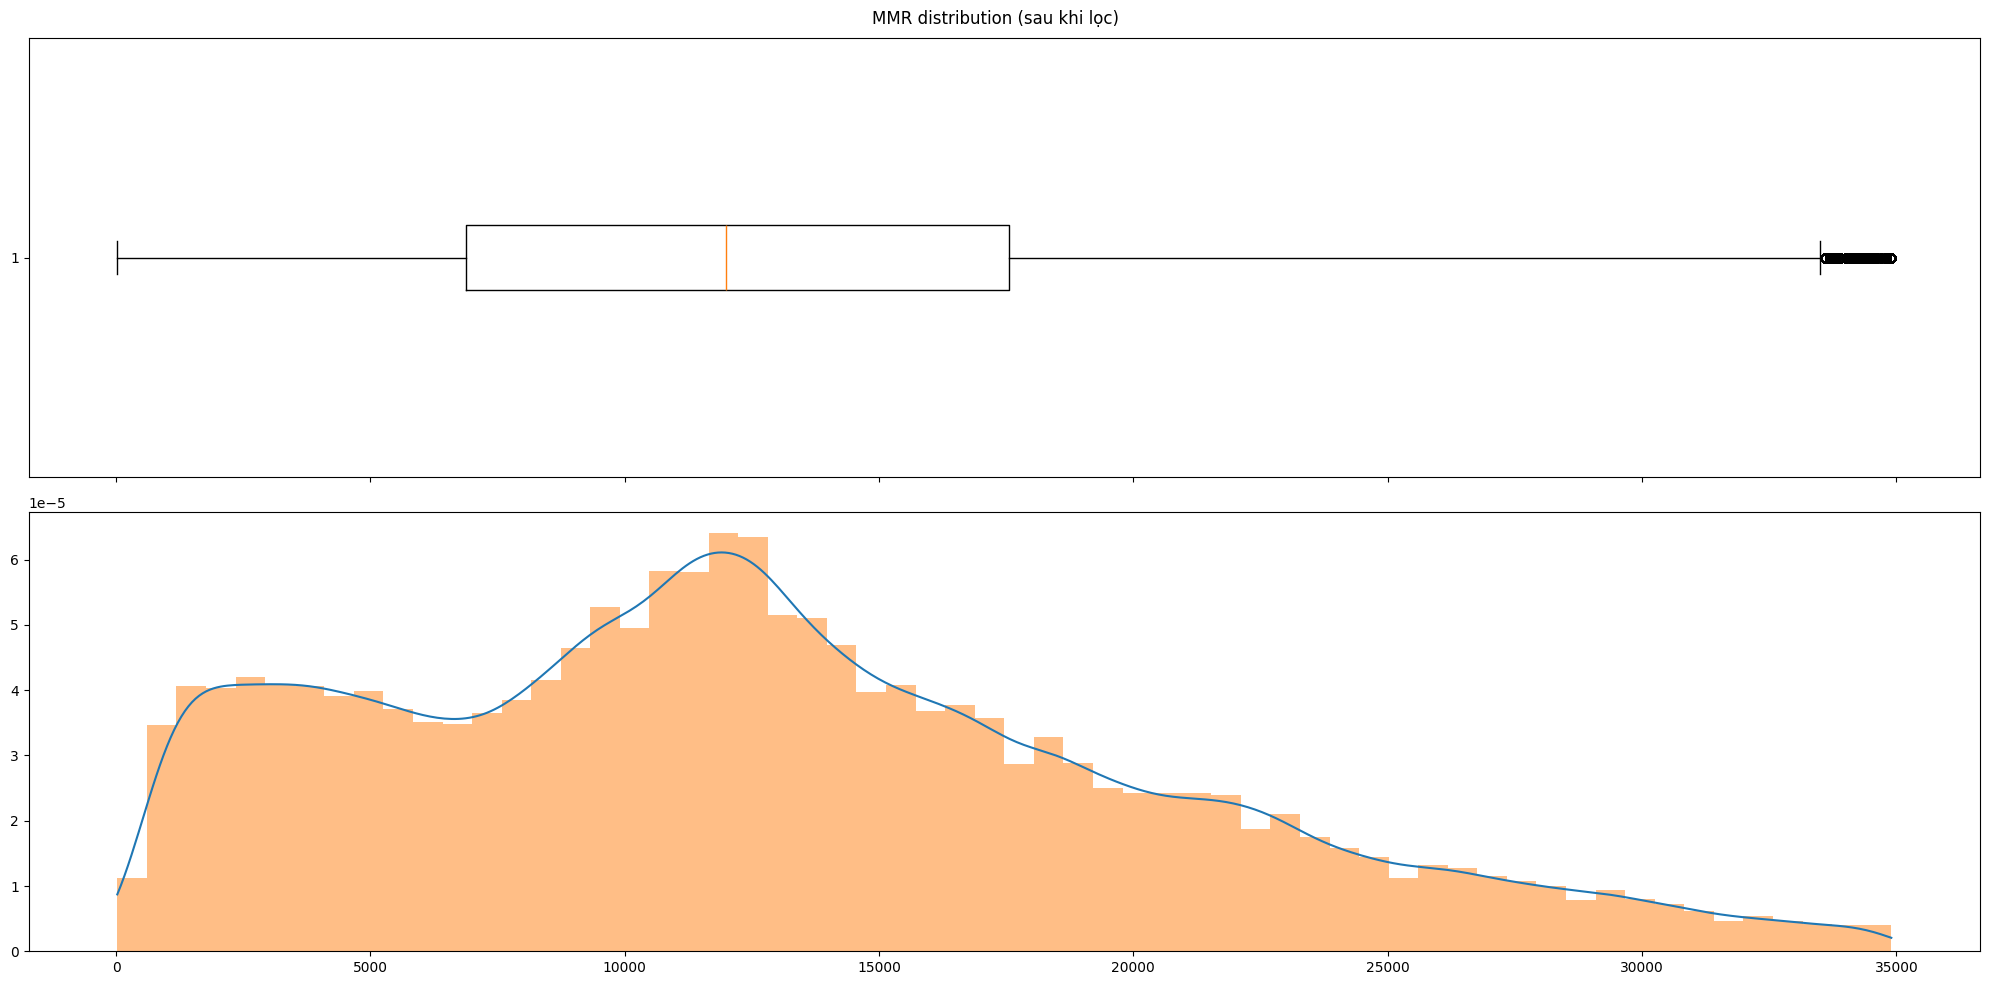

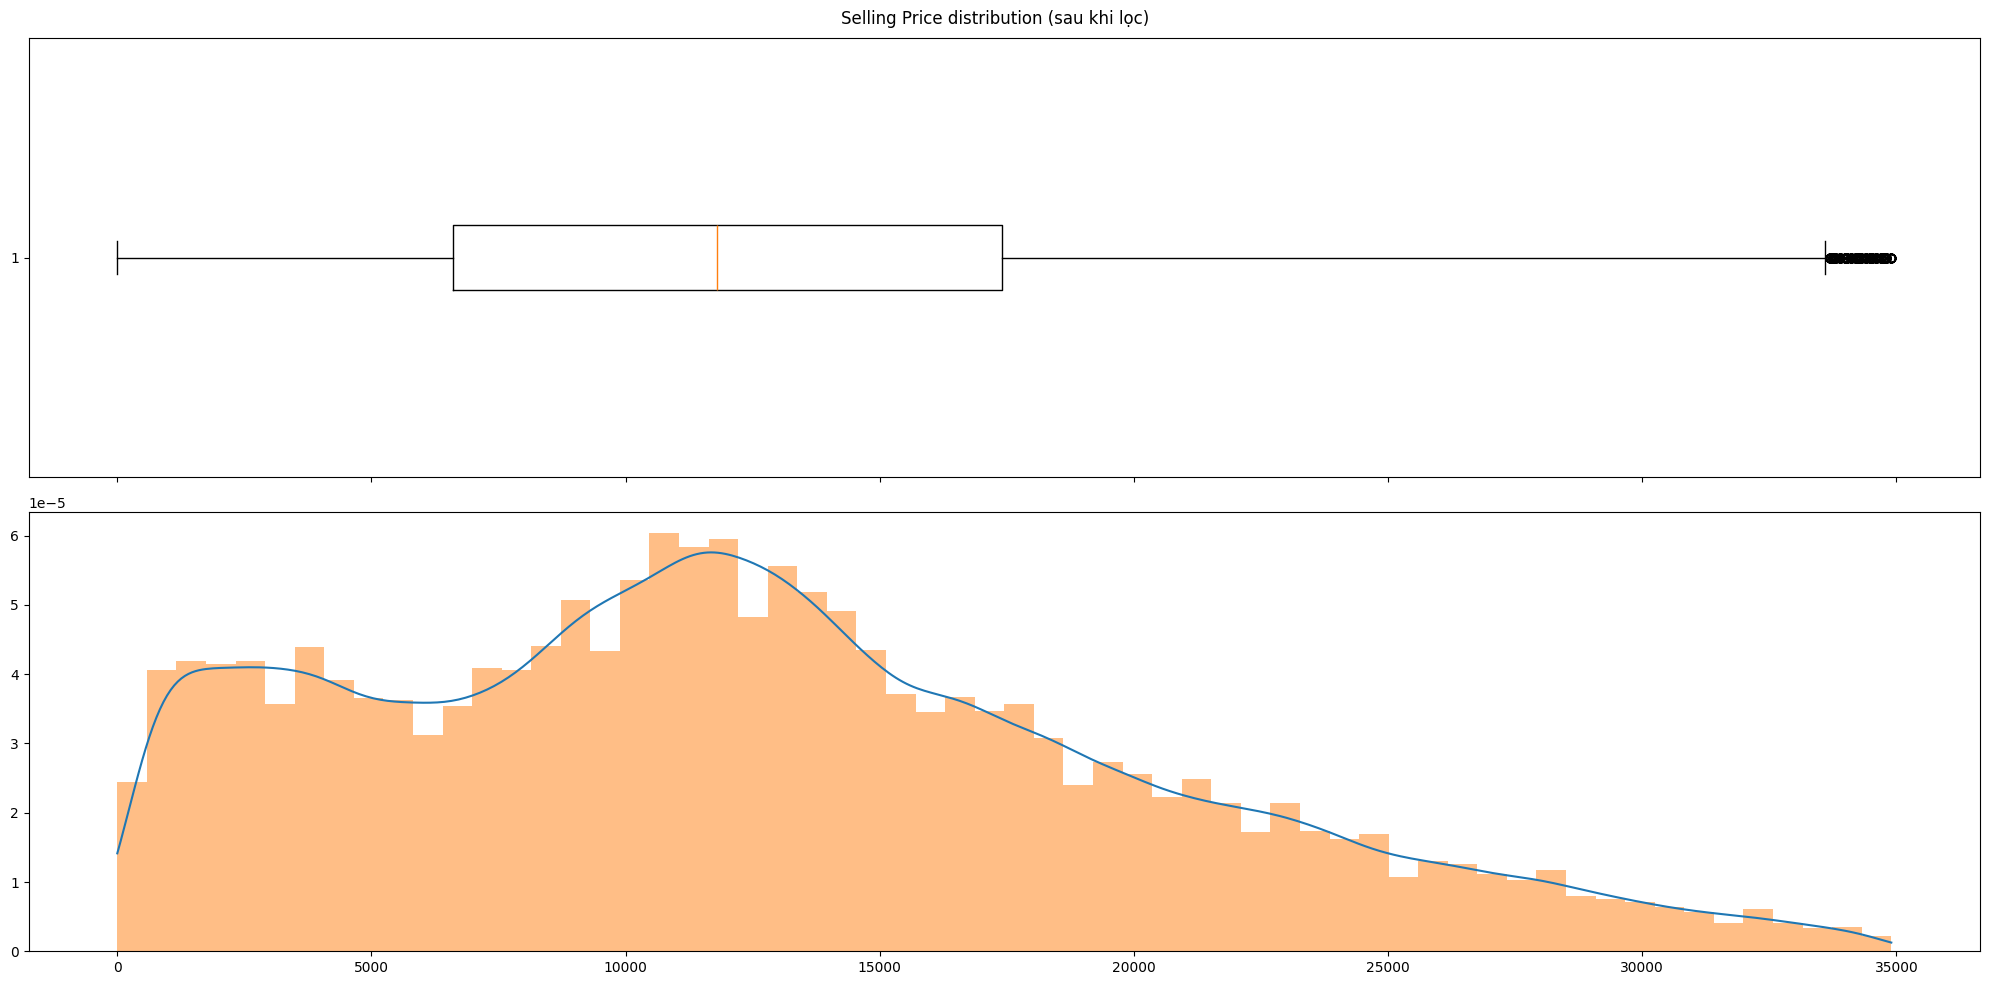

In [14]:
# Lọc dữ liệu cho Estimated Price
data1 = data.loc[data['mmr'] < 35000,:]

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(20,10),sharex=True)

kde = gaussian_kde(data1['mmr'])
kde_x = np.linspace(data1['mmr'].min(), data1['mmr'].max(), 500)

ax[0].boxplot(data1['mmr'],vert=False)

kde_y = kde(kde_x)

ax[1].plot(kde_x, kde_y, label='KDE')
ax[1].hist(data1['mmr'],bins=60,alpha=0.5,density=True)

plt.suptitle('MMR distribution (sau khi lọc)')
plt.tight_layout()
plt.show()

# Lọc dữ liệu cho Selling Price
data1 = data1.loc[data['sellingprice'] < 35000,:]

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(20,10),sharex=True)

kde = gaussian_kde(data1['sellingprice'])
kde_x = np.linspace(data1['sellingprice'].min(), data1['sellingprice'].max(), 500)

ax[0].boxplot(data1['sellingprice'],vert=False)

kde_y = kde(kde_x)

ax[1].plot(kde_x, kde_y, label='KDE')
ax[1].hist(data1['sellingprice'],bins=60,alpha=0.5,density=True)

plt.suptitle('Selling Price distribution (sau khi lọc)')
plt.tight_layout()
plt.show()



### Biểu đồ quan hệ giữa Giá Dự Đoán và Giá Bán Thực Tế (Đã được lọc)

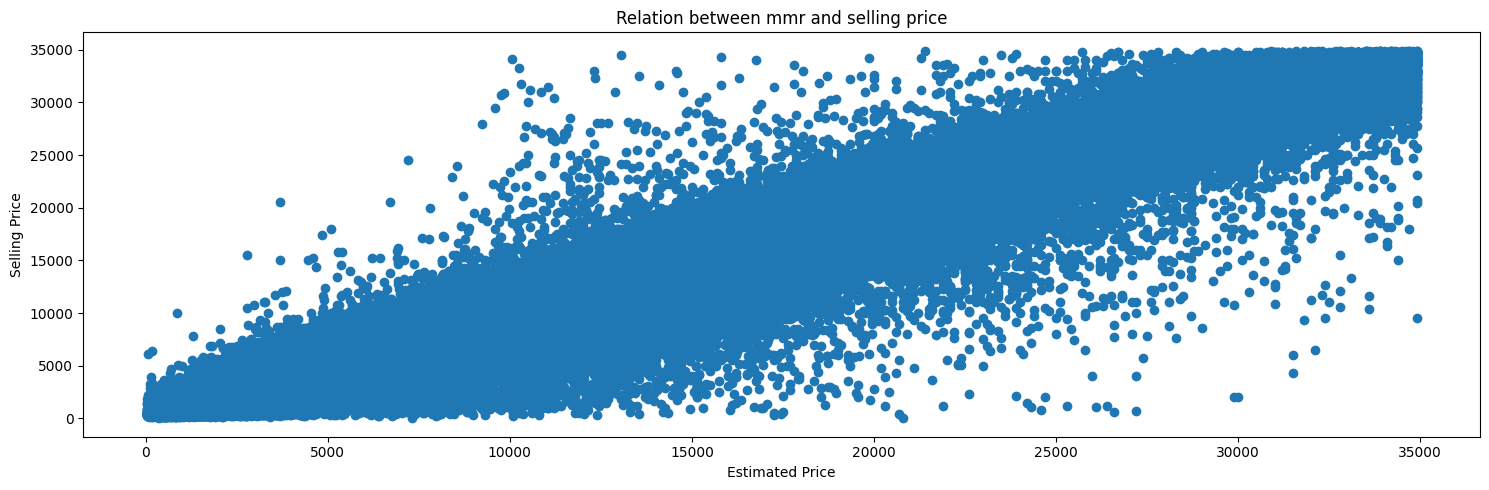

In [15]:
plt.figure(figsize=(15,5))
plt.scatter(data1['mmr'],data1['sellingprice'])
plt.xlabel("Estimated Price")
plt.ylabel('Selling Price')
plt.title("Relation between mmr and selling price")
plt.tight_layout()
plt.show()

## Simple Linear Regression với dữ liệu đã được xử lý

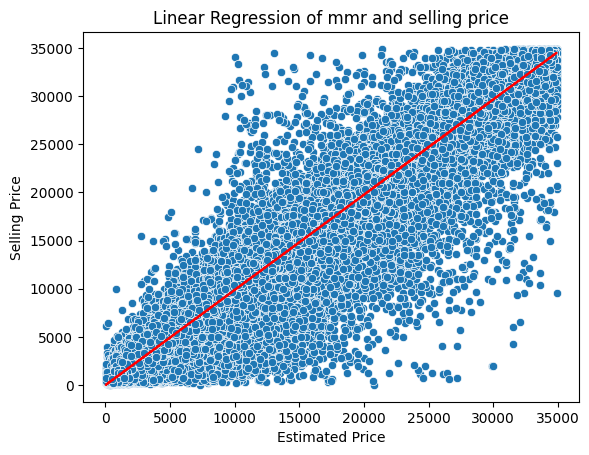

RMSE =  1599.1884282946894
MSE =  2557403.629191639
MAE =  1050.5840139134402
R^2 Score =  0.9566017888948439
Explained Variance Score =  0.9566017888948439


In [16]:
#Call SLReg function
SLReg(data1)
model, predictions, y = SLReg(data1)
#Một số hàm mất mát
RMSE=np.sqrt(sk.metrics.mean_squared_error(y, predictions))
MSE=sk.metrics.mean_squared_error(y, predictions)
MAE=sk.metrics.mean_absolute_error(y, predictions)

sns.scatterplot(data=data1,x='mmr',y='sellingprice')
plt.plot(data1['mmr'],predictions,color='red')
plt.title('Linear Regression of mmr and selling price')
plt.xlabel('Estimated Price')
plt.ylabel('Selling Price')
plt.show()

#Đánh giá model
print('RMSE = ', RMSE)
print('MSE = ', MSE)
print('MAE = ', MAE )
print('R^2 Score = ', sk.metrics.r2_score(y,predictions))
print('Explained Variance Score = ', sk.metrics.explained_variance_score(y,predictions))



#### Nhận xét Simple Linear Regression trên dữ liệu đã được lọc
- Model có độ chính xác cao với điểm R^2 và Explained Variance sấp sỉ 0.96
- Các hàm mất mát RMSE và MAE cho ra kết quả thấp 
- Hàm mất mát MSE cho ra kết quả giảm đáng kể so với khi chưa lọc dữ liệu

# Mutiple Linear Regression
- Là Linear Regression với 2 features trở lên
- Thực hiện Linear Regression với các feature số học của dataset trên
- Sử dụng dữ liệu đã được lọc outliar

In [17]:
#Tạo function Multiple Linear Regression
def MLReg(data):
    X=data.drop('sellingprice',axis=1)
    y=data[['sellingprice']]

    model=LinearRegression()
    model.fit(X,y)
    predictions=model.predict(X)

    return(model,predictions,y)

### Multiple Linear Regression với dữ liệu đã được lọc

In [18]:
#Call function MLReg
model, predictions, y = MLReg(data1)

#Một số hàm mất mát
RMSE=np.sqrt(sk.metrics.mean_squared_error(y, predictions))
MSE=sk.metrics.mean_squared_error(y, predictions)
MAE=sk.metrics.mean_absolute_error(y, predictions)

#Đánh giá model
print('RMSE = ', RMSE)
print('MSE = ', MSE)
print('MAE = ', MAE )
print('R^2 Score = ', sk.metrics.r2_score(y,predictions))
print('Explained Variance Score = ', sk.metrics.explained_variance_score(y,predictions))



RMSE =  1527.0448928736344
MSE =  2331866.1048514494
MAE =  1011.3111015416134
R^2 Score =  0.9604290788000138
Explained Variance Score =  0.9604290788000138


### Nhận xét mô hình MultiLinear Regression 
- Mô hình có độ chính xác cao, với điểm R^2 và Explained Variance score xấp sỉ 0.96
- Các chỉ số RMSE và MAE đều thấp
- Chỉ số MSE thấp hơn so với simple linear regression 

# So sánh giữa các mô hình đã tạo

## Testing datasets
- Lấy 20% random các datapoint từ data gốc để test và so sánh các model

In [19]:
X_test_S=data_test[['mmr']]
X_test_M=data_test.drop('sellingprice',axis=1)
y_test=data_test[['sellingprice']]

## Test Model

### Simple Linear Regression (Uncleaned data)

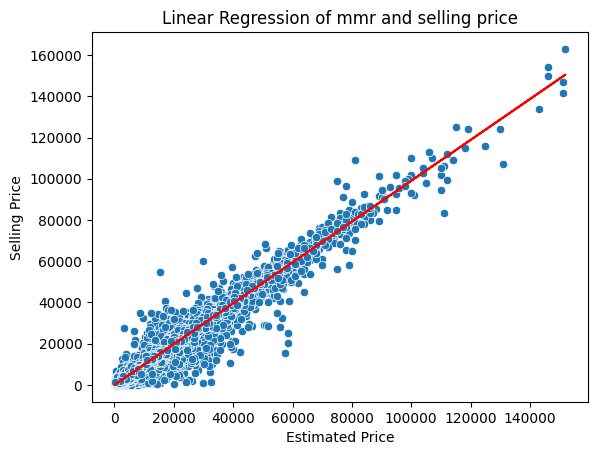

RMSE =  1738.6713272003637
MSE =  3022977.9840286747
MAE =  1091.541920405408
R^2 Score =  0.9673930081757269
Explained Variance Score =  0.9673930081757269


In [20]:
#Call function SLReg
model,_,_= SLReg(data)

predictions_test = model.predict(X_test_S)

#Một số hàm mất mát
RMSE_SLRegU=np.sqrt(sk.metrics.mean_squared_error(y_test, predictions_test))
MSE_SLRegU=sk.metrics.mean_squared_error(y_test, predictions_test)
MAE_SLRegU=sk.metrics.mean_absolute_error(y_test, predictions_test)
R2_SLRegU=sk.metrics.r2_score(y_test,predictions_test)
EVS_SLRegU=sk.metrics.explained_variance_score(y_test,predictions_test)

sns.scatterplot(data=data_test,x='mmr',y='sellingprice')
plt.plot(X_test_S,predictions_test,color='red')
plt.title('Linear Regression of mmr and selling price')
plt.xlabel('Estimated Price')
plt.ylabel('Selling Price')
plt.show()

#Đánh giá model
print('RMSE = ', RMSE_SLRegU)
print('MSE = ', MSE_SLRegU)
print('MAE = ', MAE_SLRegU )
print('R^2 Score = ', R2_SLRegU )
print('Explained Variance Score = ', R2_SLRegU )



### Simple Linear Regression (Cleaned data)

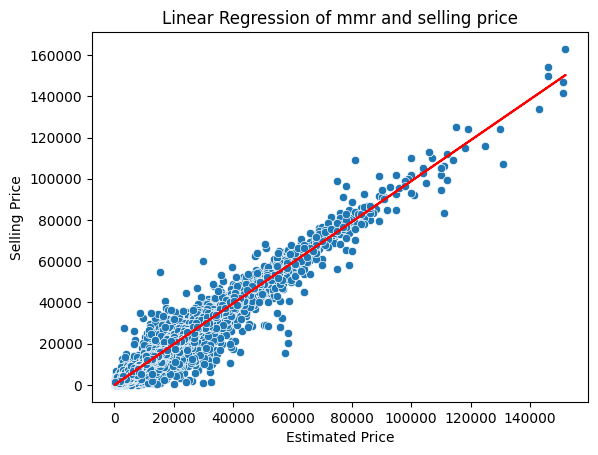

RMSE =  1738.905806200156
MSE =  3023793.4028366143
MAE =  1093.347278597652
R^2 Score =  0.9673842127579156
Explained Variance Score =  0.967388336425278


In [21]:
#Call function SLReg
model,_,_= SLReg(data1)

predictions_test = model.predict(X_test_S)

#Một số hàm mất mát
RMSE_SLRegC=np.sqrt(sk.metrics.mean_squared_error(y_test, predictions_test))
MSE_SLRegC=sk.metrics.mean_squared_error(y_test, predictions_test)
MAE_SLRegC=sk.metrics.mean_absolute_error(y_test, predictions_test)
R2_SLRegC=sk.metrics.r2_score(y_test,predictions_test)
EVS_SLRegC=sk.metrics.explained_variance_score(y_test,predictions_test)

sns.scatterplot(data=data_test,x='mmr',y='sellingprice')
plt.plot(X_test_S,predictions_test,color='red')
plt.title('Linear Regression of mmr and selling price')
plt.xlabel('Estimated Price')
plt.ylabel('Selling Price')
plt.show()

#Đánh giá model
print('RMSE = ', RMSE_SLRegC)
print('MSE = ', MSE_SLRegC)
print('MAE = ', MAE_SLRegC )
print('R^2 Score = ', R2_SLRegC)
print('Explained Variance Score = ', EVS_SLRegC)



### Multiple Linear Regression (Cleaned data)

In [22]:
#Call function MLReg
model,_,_= MLReg(data1)

predictions_test = model.predict(X_test_M)

#Một số hàm mất mát
RMSE_MLRegC=np.sqrt(sk.metrics.mean_squared_error(y_test, predictions_test))
MSE_MLRegC=sk.metrics.mean_squared_error(y_test, predictions_test)
MAE_MLRegC=sk.metrics.mean_absolute_error(y_test, predictions_test)
R2_MLRegC=sk.metrics.r2_score(y_test,predictions_test)
EVS_MLRegC=sk.metrics.explained_variance_score(y_test,predictions_test)

#Đánh giá model
print('RMSE = ', RMSE_MLRegC)
print('MSE = ', MSE_MLRegC)
print('MAE = ', MAE_MLRegC)
print('R^2 Score = ', R2_MLRegC)
print('Explained Variance Score = ', EVS_MLRegC)


RMSE =  1678.1565753392094
MSE =  2816209.491354224
MAE =  1060.6247800549636
R^2 Score =  0.9696232918846305
Explained Variance Score =  0.969631351529388


In [23]:
Model_data=pd.DataFrame({
    'Model':['Simple Linear Regression (Uncleaned)','Simple Linear Regression (Clean)','Multiple Linear Regression (Clean)'],
    'RMSE':[RMSE_SLRegU,RMSE_SLRegC,RMSE_MLRegC],
    'MSE':[MSE_SLRegU,MSE_SLRegC,MSE_MLRegC],
    'MAE':[MAE_SLRegU,MAE_SLRegC,MAE_MLRegC],
    'R^2 Score':[R2_SLRegU,R2_SLRegC,R2_MLRegC],
    'Explained Variance Score':[EVS_SLRegU,EVS_SLRegC,EVS_MLRegC]
})

Model_data.head()

,Model,RMSE,MSE,MAE,R^2 Score,Explained Variance Score
0,Simple Linear Regression (Uncleaned),1738.671327,3.022978e+06,1091.541920,0.967393,0.967393
1,Simple Linear Regression (Clean),1738.905806,3.023793e+06,1093.347279,0.967384,0.967388
2,Multiple Linear Regression (Clean),1678.156575,2.816209e+06,1060.624780,0.969623,0.969631


In [24]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 432197 entries, 1 to 558836
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   condition     432197 non-null  float64
 1   odometer      432197 non-null  float64
 2   mmr           432197 non-null  float64
 3   sellingprice  432197 non-null  float64
 4   car_age       432197 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 19.8 MB
